# Deep Dreaming in Keras

It is preferable to run this script on GPU, for speed.
If running on CPU, prefer the TensorFlow backend (much faster).

Example results: http://i.imgur.com/FX6ROg9.jpg

*Note:* you will need to have downloaded the VGG-16 weights file (H5 format), saved as `vgg16_weights.h5`.

### Settings

Edit these to change the path of the input image and the operation of deep dream.

In [1]:
# Put the path of the input image here
INPUT_IMAGE_PATH = 'dog.jpg'
# The path of the output image or `None` if you don't want it saved
OUTPUT_IMAGE_PATH = 'dreamy.png'
# Path to the model weights file.
WEIGHTS_PATH = 'vgg16_weights.h5'
# Dimensions of the generated picture
IMG_WIDTH = 600
IMG_HEIGHT = 600
# Either 'dreamy' or 'bad_trip'; see below
DREAM_TYPE = 'dreamy'


# some settings we found interesting
_SAVED_SETTINGS = {
    'bad_trip': {'features': {'conv4_1': 0.05,
                              'conv4_2': 0.01,
                              'conv4_3': 0.01},
                 'continuity': 0.1,
                 'dream_l2': 0.8,
                 'jitter': 5},
    'dreamy': {'features': {'conv5_1': 0.05,
                            'conv5_2': 0.02},
               'continuity': 0.1,
               'dream_l2': 0.02,
               'jitter': 0},
}

# the settings we will use in this experiment
SETTINGS = _SAVED_SETTINGS[DREAM_TYPE]

#### Imports

In [2]:
%matplotlib inline

from __future__ import print_function
from matplotlib import pyplot as plt
from scipy.misc import imread, imresize, imsave
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import h5py
import os

from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import backend as K

/Users/Geoff/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.


#### Utility functions for image handling
The `preprocess_image` function loads an image, scales it to the correct size and flips its channel order from RGB to BGR. The `deprocess_image` does the inverse for the purpose of display.

In [3]:
# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = imresize(imread(image_path), (IMG_WIDTH, IMG_HEIGHT))
    orig_img = img.copy()
    img = img.transpose((2, 0, 1)).astype('float64')
    img = np.expand_dims(img, axis=0)
    return img, orig_img

# util function to convert a tensor into a valid image
def deprocess_image(x):
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Build the VGG-16 network
Here we build the VGG-16 network.

In [4]:
model = Sequential()
model.add(ZeroPadding2D((1, 1), batch_input_shape=(1, 3, IMG_WIDTH, IMG_HEIGHT)))
first_layer = model.layers[-1]
# this is a placeholder tensor that will contain our generated images
dream = first_layer.input

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#### Load network weights

Load the VGG-16 network weights from the H5 file.

In [5]:
# load the weights of the VGG16 networks
# (trained on ImageNet, won the ILSVRC competition in 2014)
# note: when there is a complete match between your model definition
# and your weight savefile, you can simply call model.load_weights(filename)
assert os.path.exists(WEIGHTS_PATH), 'Model weights not found (see "weights_path" variable in script).'
f = h5py.File(WEIGHTS_PATH)
for k in range(f.attrs['nb_layers']):
    if k >= len(model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    model.layers[k].set_weights(weights)
f.close()
print('Model loaded.')

Model loaded.


#### Generate layer dictionary
The layer dictionary maps layer name to layer.

In [6]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

### The loss

The loss used for *deep dreaming* is the sum of the $L_2$-norm of the features generated by the layers listed in the settings (see above). Each layer used has a coefficient that is used to scale the contribution of the $L_2$-norm for that layer.

In [7]:
# define the loss
loss = K.variable(0.)
for layer_name in SETTINGS['features']:
    # add the L2 norm of the features of a layer to the loss
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = SETTINGS['features'][layer_name]
    x = layer_dict[layer_name].output
    shape = layer_dict[layer_name].output_shape
    # we avoid border artifacts by only involving non-border pixels in the loss
    loss -= coeff * K.sum(K.square(x[:, :, 2: shape[2]-2, 2: shape[3]-2])) / np.prod(shape[1:])

#### Continuity loss and $L_2$ norm of input image

- continuity loss; gives image local coherence, can result in an artful blur
- image L2 norm; prevents pixels from taking very high values, makes image darker

In [8]:
# continuity loss util function
def continuity_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :IMG_WIDTH-1, :IMG_HEIGHT-1] - x[:, :, 1:, :IMG_HEIGHT-1])
    b = K.square(x[:, :, :IMG_WIDTH-1, :IMG_HEIGHT-1] - x[:, :, :IMG_WIDTH-1, 1:])
    return K.sum(K.pow(a + b, 1.25))

    
# add continuity loss (gives image local coherence, can result in an artful blur)
loss += SETTINGS['continuity'] * continuity_loss(dream) / (3 * IMG_WIDTH * IMG_HEIGHT)
# add image L2 norm to loss (prevents pixels from taking very high values, makes image darker)
loss += SETTINGS['dream_l2'] * K.sum(K.square(dream)) / (3 * IMG_WIDTH * IMG_HEIGHT)

# feel free to further modify the loss as you see fit, to achieve new effects...

### Compute gradients of the input image w.r.t. loss

In [9]:
# compute the gradients of the dream wrt the loss
grads = K.gradients(loss, dream)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

Define Keras function for computing loss and gradient of image w.r.t. loss, then python function to unpack its output.

In [10]:
f_outputs = K.function([dream], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, 3, IMG_WIDTH, IMG_HEIGHT))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

#### Evaluator utility class

This `Evaluator` class makes it possible
to compute loss and gradients in one pass
while retrieving them via two separate functions,
`loss` and `grads`. This is done because `scipy.optimize`
requires separate functions for loss and gradients,
but computing them separately would be inefficient.

In [11]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## Lets start deep dreaming!!!

Run scipy-based optimization (L-BFGS) over the pixels of the generated image
so as to minimize the loss.

Input image:


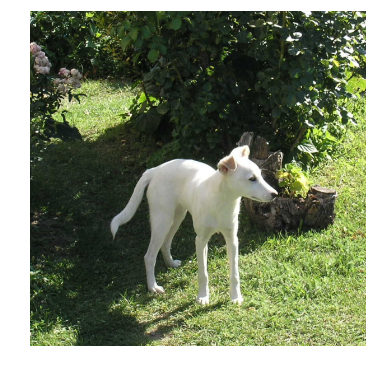

Start of iteration 0
Current loss value: -52.7721594062
Iteration 0 completed in 72s


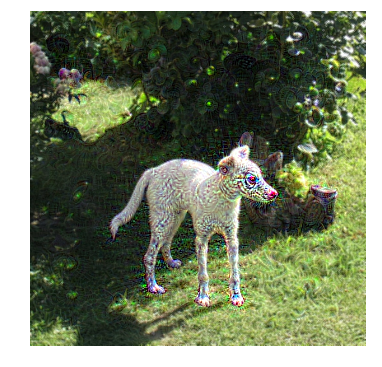

Start of iteration 1
Current loss value: -2007.7598362
Iteration 1 completed in 69s


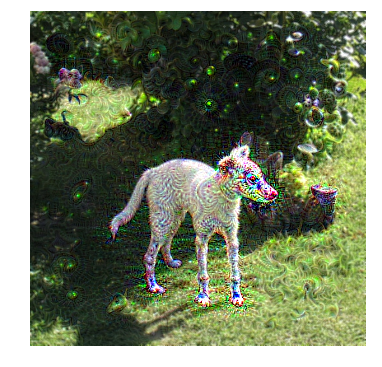

Start of iteration 2
Current loss value: -9356.18566565
Iteration 2 completed in 72s


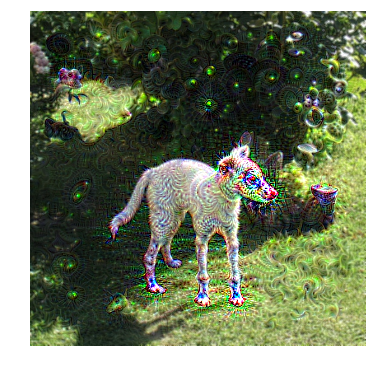

Start of iteration 3
Current loss value: -27900.1157553
Iteration 3 completed in 76s


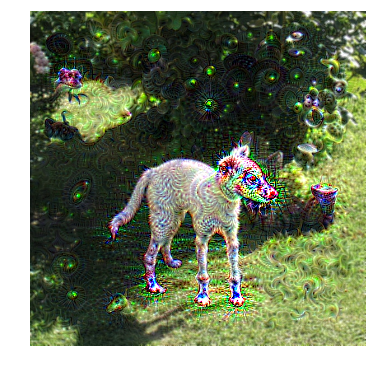

Start of iteration 4
Current loss value: -69073.2495606
Iteration 4 completed in 76s


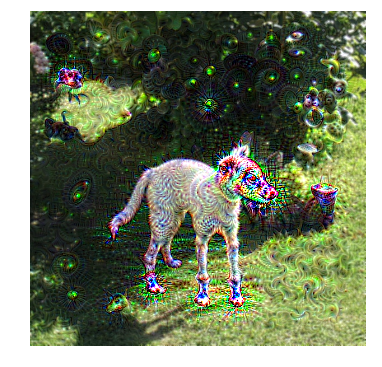

Written final image to dreamy.png


In [12]:
# Load the input image and pre-process it
x, orig_img = preprocess_image(INPUT_IMAGE_PATH)

# Show the input image
print('Input image:')
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(orig_img)
plt.show()

for i in range(5):
    print('Start of iteration', i)
    start_time = time.time()

    # add a random jitter to the initial image. This will be reverted at decoding time
    random_jitter = (SETTINGS['jitter'] * 2) * (np.random.random((3, IMG_WIDTH, IMG_HEIGHT)) - 0.5)
    x += random_jitter

    # run L-BFGS for 7 steps
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print('Current loss value:', min_val)
    # decode the dream and save it
    x = x.reshape((3, IMG_WIDTH, IMG_HEIGHT))
    x -= random_jitter
    img = deprocess_image(x)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

    # Show the image so far
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
# Save the final result
if OUTPUT_IMAGE_PATH is not None and OUTPUT_IMAGE_PATH != '':
    imsave(OUTPUT_IMAGE_PATH, img)
    print('Written final image to {}'.format(OUTPUT_IMAGE_PATH))